# Calibration d'une caméra grace à un ChAruco Board

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
ARUCO_DICT = {
    "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
    "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
    "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
    "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
    "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
    "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
    "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
    "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
    "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
    "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
    "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
    "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
    "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
    "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
    "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
    "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
    "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
    "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
    "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
    "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11,
}

## Génération du board de calibration

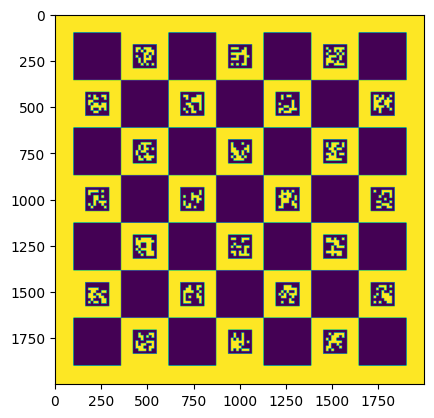

In [3]:
ArUcoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT["DICT_7X7_50"])

ChArUcoBoard = cv2.aruco.CharucoBoard((7, 7), 0.04, 0.02, ArUcoDict)

img = np.zeros((2000, 2000), dtype=np.uint8)

ChArUcoBoard.generateImage(img.shape, img, 100)

cv2.imwrite("img/charucoBoard.png", img)

plt.imshow(img)

## Importation des images de calibration

In [17]:
images_path = "./img/calib/"

images = np.array(
    [images_path + f for f in os.listdir(images_path) if f.endswith(".jpg")]
)

print(images)

['./img/calib/imgCal3.jpg' './img/calib/imgCal2.jpg'
 './img/calib/imgCal1.jpg']


## Détection des coins du board chAruco

In [24]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, ArUcoDict)

        if len(corners) > 0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(
                    gray, corner, winSize=(3, 3), zeroZone=(-1, -1), criteria=criteria
                )
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, ChArUcoBoard)
            if (
                res2[1] is not None
                and res2[2] is not None
                and len(res2[1]) > 3
                and decimator % 1 == 0
            ):
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator += 1

    imsize = gray.shape
    return allCorners, allIds, imsize

## Calibration de la caméra

In [27]:
def calibrate_camera(allCorners, allIds, imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array(
        [
            [1000.0, 0.0, imsize[0] / 2.0],
            [0.0, 1000.0, imsize[1] / 2.0],
            [0.0, 0.0, 1.0],
        ]
    )

    distCoeffsInit = np.zeros((5, 1))
    flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS
        + cv2.CALIB_RATIONAL_MODEL
        + cv2.CALIB_FIX_ASPECT_RATIO
    )
    # flags = (cv2.CALIB_RATIONAL_MODEL)
    (
        ret,
        camera_matrix,
        distortion_coefficients0,
        rotation_vectors,
        translation_vectors,
        stdDeviationsIntrinsics,
        stdDeviationsExtrinsics,
        perViewErrors,
    ) = cv2.aruco.calibrateCameraCharucoExtended(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=ChArUcoBoard,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=distCoeffsInit,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9),
    )

    return (
        ret,
        camera_matrix,
        distortion_coefficients0,
        rotation_vectors,
        translation_vectors,
    )

## Utilisation

In [29]:
allCorners, allIds, imsize = read_chessboards(images)

print("allCornes : ", allCornes)
print("allIds : ", allIds)
print("imsize : ", imsize)

ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners, allIds, imsize)

print("ret : ", ret)
print("mtx : ", mtx)
print("dist : ", dist)
print("rvecs : ", rvecs)
print("tvecs : ", tvecs)

POSE ESTIMATION STARTS:
=> Processing image ./img/calib/imgCal3.jpg
=> Processing image ./img/calib/imgCal2.jpg
=> Processing image ./img/calib/imgCal1.jpg
allCornes :  [array([[[1936.9493 ,  705.0695 ]],

       [[1926.6335 ,  790.01685]],

       [[1915.0986 ,  876.75916]],

       [[1904.0231 ,  964.8965 ]],

       [[1891.1228 , 1053.741  ]],

       [[1878.6722 , 1147.4706 ]],

       [[1843.902  ,  699.0129 ]],

       [[1832.0503 ,  784.1304 ]],

       [[1819.6273 ,  869.2048 ]],

       [[1806.1699 ,  957.35394]],

       [[1792.677  , 1046.9894 ]],

       [[1778.319  , 1140.213  ]],

       [[1750.3529 ,  694.31744]],

       [[1737.5264 ,  777.82477]],

       [[1723.3315 ,  862.7778 ]],

       [[1709.059  ,  950.6944 ]],

       [[1693.522  , 1039.8792 ]],

       [[1678.379  , 1134.0018 ]],

       [[1658.5304 ,  689.0328 ]],

       [[1643.796  ,  771.27747]],

       [[1628.644  ,  856.2489 ]],

       [[1612.4702 ,  943.24133]],

       [[1595.9504 , 1033.2091 ]],

  

## Test de calibration

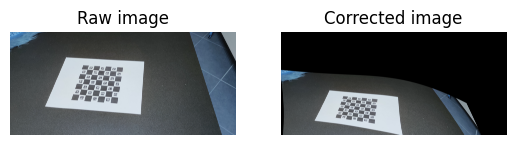

In [31]:
plt.figure()
frame = cv2.imread(images[1])
img_undist = cv2.undistort(frame, mtx, dist, None)
cv2.imwrite("img/calib/undist.jpg", img_undist)
cv2.imwrite("img/calib/dist.jpg", frame)
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## Estimation de translation 3D

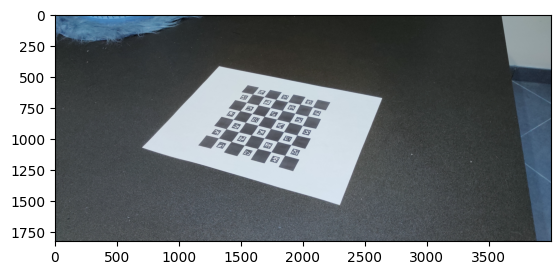

In [32]:
frame = cv2.imread("img/calib/imgCal1.jpg")

plt.figure()
plt.imshow(frame)
plt.show()

### Post processing

In [34]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

parameters = cv2.aruco.DetectorParameters()

corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, ArUcoDict, parameters)